# Verschmelzen von Labels basierend auf Zentroid-Abständen
In diesem Notebook werden wir Labels in einem Label-Bild basierend auf ihren Zentroid-Abständen zueinander verschmelzen. Nahe beieinander liegende Labels werden zusammengeführt.

Siehe auch
* [Image.sc Diskussion](https://forum.image.sc/t/measure-distances-between-labels/79125)
* [Verschmelzen von Labels mit napari-accelerated-pixel-and-object-classifiers](https://github.com/haesleinhuepf/napari-accelerated-pixel-and-object-classification#merging-objects)

In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread

Zu Demonstrationszwecken verwenden wir eine modifizierte Version der Labels, die aus dem Blobs-Beispielbild abgeleitet wurden. Wir führen künstlich Lücken zwischen ihnen ein.

cl.OCLArray([[ 0,  0,  0, ..., 45, 45, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
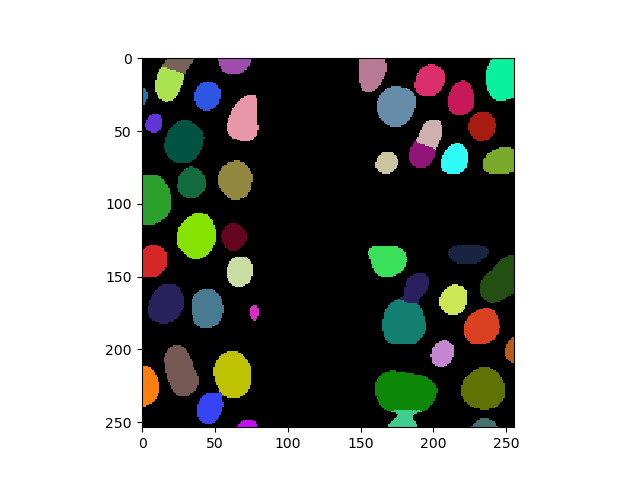

In [2]:
image = imread("../../data/blobs.tif")
image[:, 80:150] = 0
image[80:130, 100:] = 0

image = cle.asarray(image)
labels = cle.voronoi_otsu_labeling(image, spot_sigma=4, outline_sigma=3)
labels

Aus diesem Bild extrahieren wir die Koordinaten der Zentroide. Aus diesen Zentroiden können wir eine Abstandsmatrix erstellen. In dieser Matrix wird der Abstand aller Zentroide zu allen anderen Zentroiden berechnet. Die Diagonale ist null, da sie dem Abstand eines Zentroids zu sich selbst entspricht. Außerdem ist der Abstand zum Hintergrund (erste Zeile und erste Spalte) ebenfalls null, da der Hintergrund bei der Abstandsberechnung nicht berücksichtigt wird.

cl.OCLArray([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 199.36461 , ..., 245.29527 , 274.9624  ,
        306.2263  ],
       [  0.      , 199.36461 ,   0.      , ..., 321.00064 , 250.97119 ,
        249.23108 ],
       ...,
       [  0.      , 245.29527 , 321.00064 , ...,   0.      , 139.21213 ,
        186.94691 ],
       [  0.      , 274.9624  , 250.97119 , ..., 139.21213 ,   0.      ,
         48.239468],
       [  0.      , 306.2263  , 249.23108 , ..., 186.94691 ,  48.239468,
          0.      ]], dtype=float32)
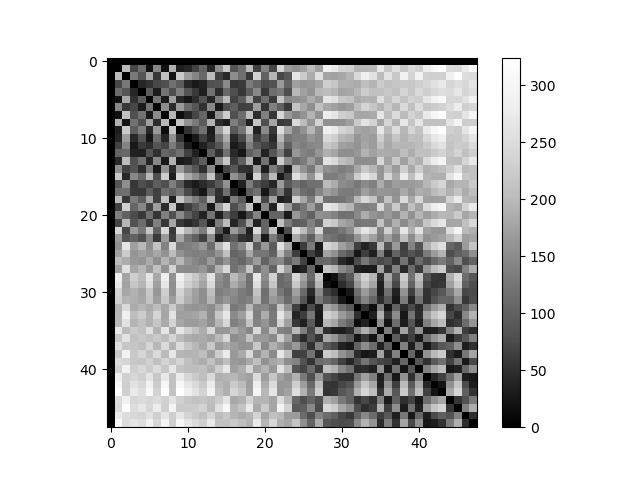
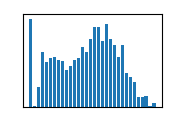

In [3]:
centroids = cle.centroids_of_labels(labels)

distance_matrix = cle.generate_distance_matrix(centroids, centroids)
distance_matrix

Wir können diese Abstandsmatrix mit einem gegebenen maximalen Abstand schwellenwertbasiert verarbeiten. Das Ergebnis ist eine binäre Matrix.

cl.OCLArray([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1]], dtype=uint8)
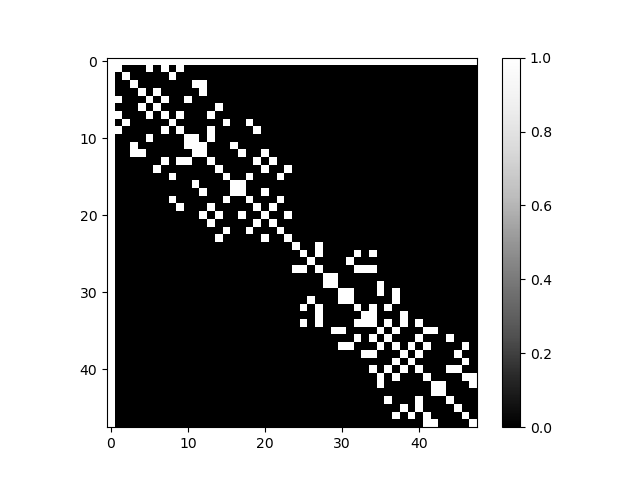
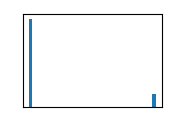

In [4]:
maximum_distance = 40

merge_matrix = distance_matrix <= maximum_distance
merge_matrix

Wenn wir Labels mit dem Hintergrund verschmelzen würden, würden alle Labels verschmolzen werden, da alle den Hintergrund berühren. Um dies zu verhindern, setzen wir die erste Zeile und Spalte auf null.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)
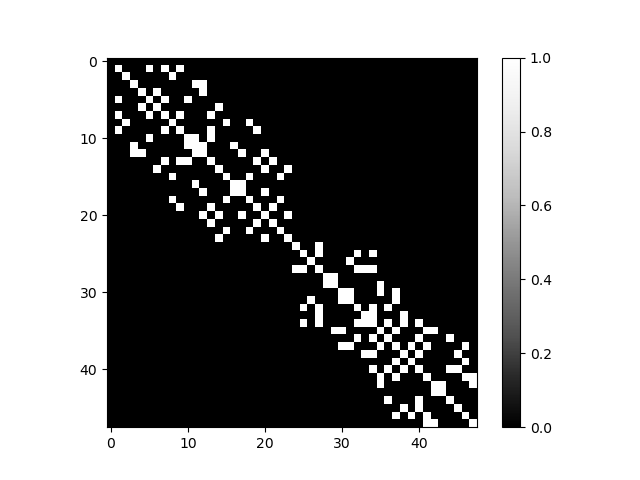
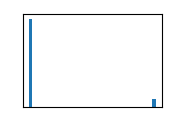

In [5]:
cle.set_column(merge_matrix, 0, 0)
cle.set_row(merge_matrix, 0, 0)

merge_matrix

Mit der obigen binären Matrix können wir nun die Labels entsprechend verschmelzen.

cl.OCLArray([[0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
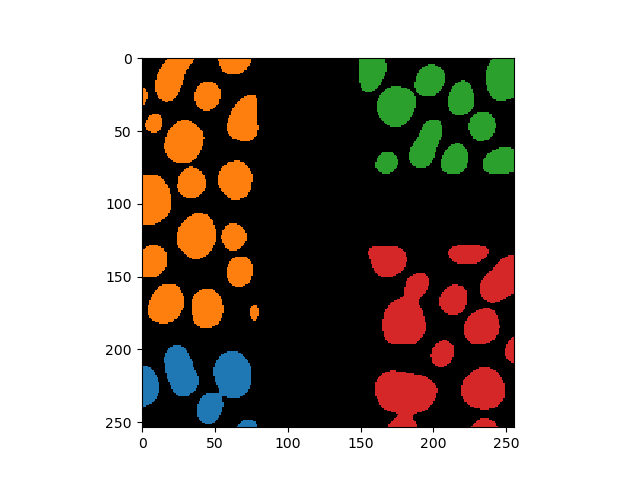

In [6]:
merged_labels = cle.merge_labels_according_to_touch_matrix(labels, merge_matrix)
merged_labels